In [3]:
import pandas as pd
import numpy as np
import plotly.express as px
import openai 
from transformers import GPT2TokenizerFast
from config import API_KEY_OPENAI #API key for openai

### Overview: 
In this project, I gathered an Electricity Co-op (Co-op A) Google Revews using serpapi, processed the data (in a seperate notebook), and analyzed it. In this notebook, I will analyze rating score overtime and perform reviews analysis using wordcloud and OpenAI GPT

## 0. Classifying reviews
Classified reviews into positive,  negative, let’s build wordclouds for each!
- Positive: 3,4,5 star
- Negative: 1,2 star

In [5]:
df = pd.read_csv("data/processed/CoopA_processed.csv") #This should be replaced by the actual processed csv file
df['sentiment'] = df['Rating'].apply(lambda rating : +1 if rating >= 3 else -1)
df = df.drop(columns=["Customer Name"]) #Dropping Customer name for the public version

In [6]:
df.head()

,Year,Rating,Review,sentiment
0,2023,5.0,Customer service is excellent. I’ve never had ...,1
1,2023,5.0,Awesome customer service,1
2,2023,5.0,Friendly staff,1
3,2023,5.0,Christa K. was very nice and very helpful. It ...,1
4,2023,5.0,NaN,1


## 1. Rating score overview
- Pie chart showing the distribution of score

In [23]:
#Rating count table
rating_count_table = df["Rating"].value_counts().rename_axis('Rating').reset_index(name='counts')
rating_count_table

,Rating,counts
0,5.0,256
1,1.0,97
2,4.0,17
3,2.0,4
4,3.0,3


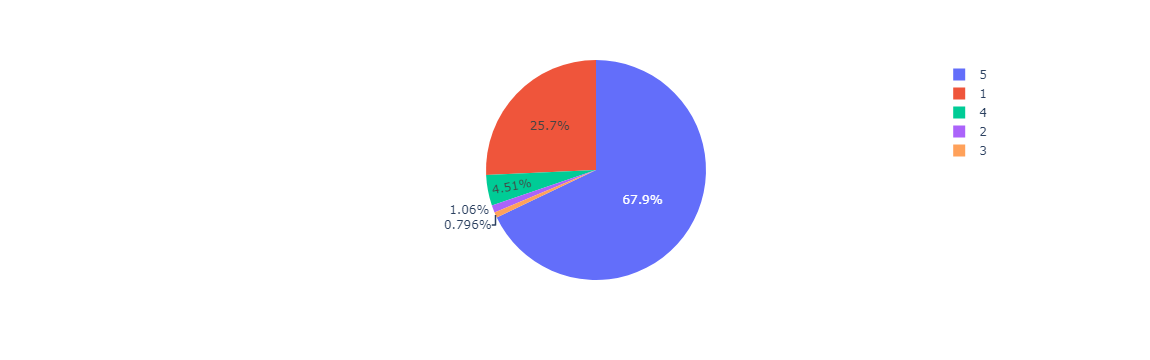

In [24]:
fig = px.pie(rating_count_table, values='counts', names='Rating')
fig.show()

#### How about last year 2022

In [25]:
#Rating count table 2022
df_2022 = df[df["Year"]==2022].copy()
rating_count_table_22 = df_2022["Rating"].value_counts().rename_axis('Rating').reset_index(name='counts')
rating_count_table_22

,Rating,counts
0,5.0,106
1,1.0,11
2,4.0,5
3,3.0,1
4,2.0,1


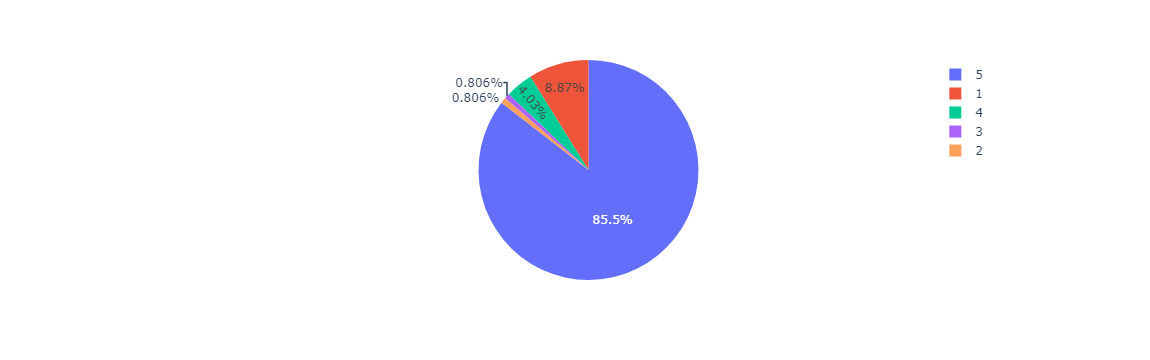

In [26]:
fig = px.pie(rating_count_table_22, values='counts', names='Rating')
fig.show()

## 2. Rating over the year
- Average yearly rating 2014-2023 (ignoring 2023 for now)
- Graph by year

In [27]:
rating_over_the_year = df.groupby("Year", as_index=False)["Rating"].agg(['mean', 'count']).reset_index()
rating_over_the_year = rating_over_the_year.rename(columns={"mean":'Avg Rating',"count":"# of Ratings"})
rating_over_the_year = rating_over_the_year[rating_over_the_year["Year"]<2023]

In [28]:
rating_over_the_year

,Year,Avg Rating,# of Ratings
0,2014,1.000000,2
1,2015,1.000000,1
2,2016,2.600000,5
3,2017,2.052632,19
4,2018,2.166667,24
5,2019,1.717949,39
6,2020,3.740741,54
7,2021,4.747475,99
8,2022,4.564516,124


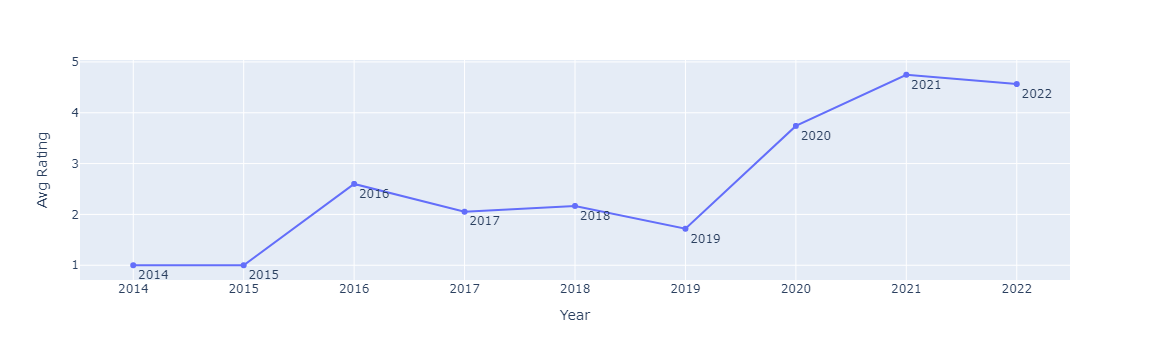

In [29]:
import plotly.express as px

fig = px.line(rating_over_the_year, x="Year", y="Avg Rating", text="Year")
fig.update_traces(textposition="bottom right")
fig.show()

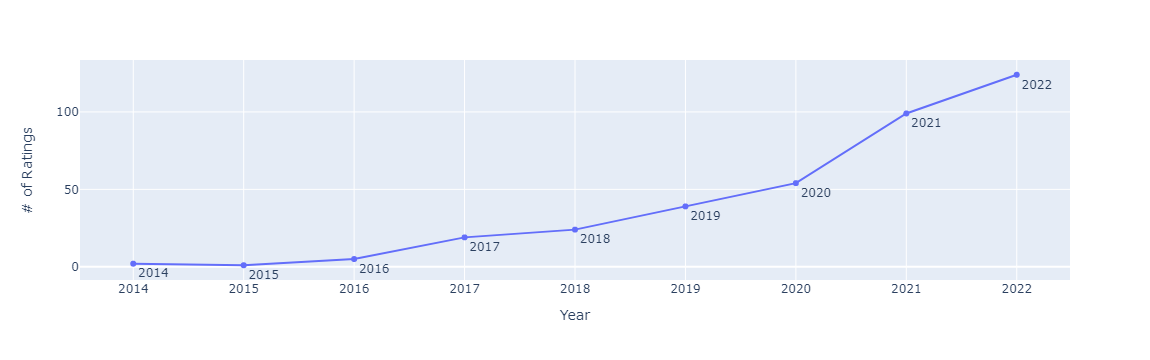

In [30]:
fig = px.line(rating_over_the_year, x="Year", y="# of Ratings", text="Year")
fig.update_traces(textposition="bottom right")
fig.show()

**Conclusion:**
The average rating of the coop increases over the years. In particular, it shows a significant increase in 2020 and 2021, followed by a slight decrease in 2022. In 2019, we have only around 1.7 star while in 2021, we have an average rating of 4.7 and around 4.5 last year

## 3. Reviews analysis

First, we will create 2 data frames — one with all the positive reviews, and another with all the negative reviews. Assuming that Positive reviews are those with score over 3 stars

In [31]:
only_review = df[~df["Review"].isna()].copy()

In [32]:
import nltk
from wordcloud import WordCloud, STOPWORDS

### Wordcloud

In [39]:
positive.head(10)

,Customer Name,Year,Rating,Review,sentiment
0,Chris Helin,2023,5.0,Customer service is excellent. I’ve never had ...,1
1,Cheryl Minichilli,2023,5.0,Awesome customer service,1
2,Scott Herman,2023,5.0,Friendly staff,1
3,M H,2023,5.0,Christa K. was very nice and very helpful. It ...,1
5,Michael Connor,2023,5.0,Deb the customer service rep was well versed o...,1
6,DAVID landon,2023,5.0,Great service fast and friendly staffing,1
7,Jenna Frick,2023,5.0,Thank you for coming out so quickly to get our...,1
8,Boris Milicevic,2023,5.0,"TRUCKERS ... awesome place to deliver to, hour...",1
10,Loren Johnson,2022,5.0,Beth was wonderful....getting things set was e...,1
12,Justin Drum,2022,5.0,I'd like to thank the asplundh crew that came ...,1


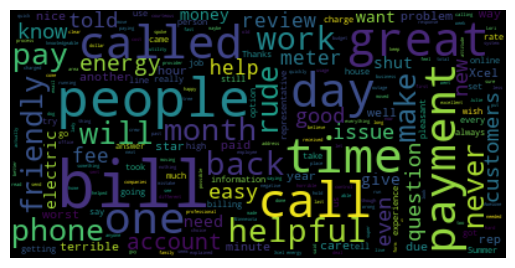

In [33]:
import nltk
from wordcloud import WordCloud, STOPWORDS
from nltk.corpus import stopwords
import matplotlib.pyplot as plt


# Create stopword list:
stopwords = set(STOPWORDS)
stopwords.update(["br", "href", "Connexus","company","customer","service","Thank","power"])
textt = " ".join(review for review in only_review.Review)
wordcloud = WordCloud(stopwords=stopwords).generate(textt)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.savefig('wordcloud11.png')
plt.show()

In [34]:
positive = only_review[only_review['sentiment'] == 1]
negative = only_review[only_review['sentiment'] == -1]

#### Negative Reviews

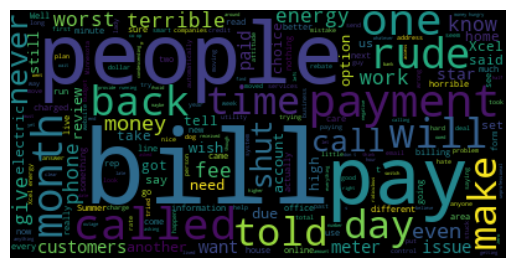

In [35]:
stopwords_bad = stopwords
stopwords_bad.update(["br", "href","bad","awful"]) 
## good and great removed because they were included in negative sentiment
pos = " ".join(review for review in negative.Review)
wordcloud2 = WordCloud(stopwords=stopwords_bad).generate(pos)
plt.imshow(wordcloud2, interpolation='bilinear')
plt.axis("off")
plt.show()

#### Positive Reviews

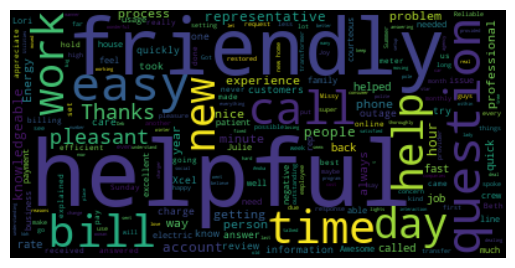

In [37]:
stopwords_good = stopwords
stopwords_good.update(["br", "href","good","great"]) 
## good and great removed because they were included in negative sentiment
pos = " ".join(review for review in positive.Review)
wordcloud2 = WordCloud(stopwords=stopwords_good).generate(pos)
plt.imshow(wordcloud2, interpolation='bilinear')
plt.axis("off")
plt.show()

**Conclusion:**  I can see that many reviews were related to billing system, payment process, call center representatives' attitude.

### Using OpenAI's GPT-3 to analyze reviews in 2023

In [102]:
def count_token(string):
    tokenizer = GPT2TokenizerFast.from_pretrained("gpt2")
    encoded = tokenizer.encode(string)
    numberOfTokens = len(encoded)
    return numberOfTokens

def reviews_to_str(dataframe):
    str_review = ">,<".join(review for review in dataframe.Review)
    str_review = "<"+str_review+">"
    years = list(dataframe["Year"].unique())
    print("Years reviewd:",years)
    return str_review

#### Positive review

In [103]:
positive_year = positive[(positive["Year"]>=2023)&(positive["Year"]<=2023)].copy()
reviews = reviews_to_str(positive_year)
num_tokens = count_token(reviews)
num_tokens

Years reviewd: [2023]


189

In [121]:
# Initialize the OpenAI API client
openai.api_key = API_KEY_OPENAI

# Generate a summary of all the reviews
response = openai.Completion.create(
    engine="text-davinci-002",
    prompt = "Generate a summary of the reviews for Coop A that includes 5 main themes. Here are the reviews, they are stored in <> and sperated by a comma: " + reviews,
    max_tokens=1000,
    n=1,
    stop=None,
    temperature=0.5,
)

# Print the summary
summary = response["choices"][0]["text"]
print(summary)



-Customer service is excellent, with a friendly and quick staff.
-The company is responsive and quick to fix any issues.
-The staff is well-informed and able to answer any questions.
-The company is professional and courteous.
-The company is quick to respond to any issues.


##### Using chat GPT 4 (the famous one) we can get:
In 2021-2022, members gave these postitive reviews for Coop A because of the following reasons:
- Excellent customer service: Many customers were impressed with the professionalism and knowledge of the customer service representatives. They were able to answer questions and resolve issues in a timely and efficient manner.
- Real person to talk to: Some customers appreciated that they were able to speak to a real person when they called the company, as opposed to navigating through an automated system.
- Helpful and friendly representatives: Customers were pleased with the helpful and friendly nature of the representatives, who went out of their way to assist them.
- Quick resolution of issues: Some customers appreciated the quick resolution of their issues, such as power outages, by Coop A's field crew.
- Ease of setting up a new account: Customers found the process of setting up a new account with Coop A to be quick and easy, thanks to the helpful representatives.
- Affordable payment arrangements: Customers appreciated the company's willingness to accommodate their needs during difficult financial times and offer affordable payment arrangements.
- Reliable service: Customers appreciated the reliable and efficient service provided by Coop A.
- Easy to use online tools: Some customers found the online tools, such as the budget monthly bill program and the chat dashboard, to be helpful and easy to use.

#### Negative reiview (in 2022 since CNXS haven't got any negative reivews in 2023 yet)
- To save some free credit, I will just run 10 random reviews in 2022

In [106]:
negative_year = negative[(negative["Year"]>=2022)&(negative["Year"]<=2022)].copy()
negative_sample = negative_year.sample(n=10)
reviews_neg = reviews_to_str(negative_sample)
num_tokens = count_token(reviews_neg)
num_tokens

Years reviewd: [2022]


671

In [116]:
# Generate a summary of all the reviews
response = openai.Completion.create(
    engine="text-davinci-002",
    prompt = "Generate a summary of the reviews for Coop A that includes 5 main themes with explaination. Here are the reviews, they are stored in <> and sperated by a comma: " + reviews_neg,
    max_tokens=1000,
    n=1,
    stop=None,
    temperature=0.5,
)

# Print the summary
summary = response["choices"][0]["text"]
print(summary)



-Rude customer service
-Shut off service without warning or payment plan
-Unfair pricing
-Unresponsive to customer concerns
-Poor quality service


##### Using chat GPT 4 we can get:
In 2020-2022, members gave these negative reviews for Coop A because of the following reasons:
- Poor customer service: Many customers have reported rude and unhelpful customer service, leading to frustration and dissatisfaction.
- Billing issues: Customers have experienced incorrect billing, including incorrect application of payments and high bills, leading to confusion and financial stress.
- Poor management of energy service: Customers have reported frequent shut-offs, long wait times for service, and a lack of action on reported issues.
- Corporate greed: Customers have criticized the company for being a monopoly and for lacking empathy for customers facing financial difficulties.
- Technical issues: Customers have reported power outages and other technical problems with their energy service, leading to inconvenience and frustration.
- Budget billing: Customers have criticized the company for unclear budget billing policies and procedures, leading to confusion and frustration.
- Fees: Customers have expressed dissatisfaction with fees charged by the company, including deposit fees, reconnect fees, and late fees, which can be substantial and add to financial stress.
- Communication problems: Customers have reported poor communication from the company, including confusing or incorrect information, leading to frustration and dissatisfaction.
- Inadequate customer service training: Customers have criticized the customer service team for lacking knowledge and skills, leading to frustration and dissatisfaction.
- Limited options: Customers have expressed frustration with the lack of options for energy providers, leading to a sense of powerlessness and dissatisfaction.
- Unprofessionalism: Customers have reported unprofessional behavior from company representatives, including lack of empathy and poor communication skills, leading to frustration and dissatisfaction.
- Inconvenient payment processes: Customers have reported inconvenience in paying their bills, including unclear policies and processes, leading to frustration and dissatisfaction.

#### Note:
- GPT3 API Can analyze more review but I was using free credit, so I only input small amount of review